In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc
import logging
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"

In [4]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # this is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [5]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}m5_final_data.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 8177.01 Mb to 4728.24 Mb (42.2% reduction)

Initial data loading complete.


In [6]:
print(df.head().to_markdown())

|    | item_id     | dept_id   | cat_id   | store_id   | state_id   |   sales |   sell_price |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   has_sale |   quarter |   week |   day_of_week |   day_of_month |   day_of_year |   price_mean |   price_relative_to_mean |   price_change_lag |   sales_lag_7 |   sales_lag_14 |   sales_lag_28 |   sales_rolling_mean_28 |   month_sin |   month_cos |   day_of_month_sin |   day_of_month_cos |   day_of_week_sin |   day_of_week_cos |
|---:|:------------|:----------|:---------|:-----------|:-----------|--------:|-------------:|-------:|--------:|-------:|----------:|----------:|----------:|:---------------|:---------------|:---------------|:---------------|-----------:|----------:|-------:|--------------:|---------------:|--------------:|-------------:|-------------------------:|-------------------:|--------------:|---------------:|---------------:|-------------------

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 36 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   item_id                 category
 1   dept_id                 category
 2   cat_id                  category
 3   store_id                category
 4   state_id                category
 5   sales                   int16   
 6   sell_price              float32 
 7   wday                    int8    
 8   month                   int8    
 9   year                    int16   
 10  snap_CA                 int8    
 11  snap_TX                 int8    
 12  snap_WI                 int8    
 13  event_name_1            category
 14  event_type_1            category
 15  event_name_2            category
 16  event_type_2            category
 17  has_sale                int8    
 18  quarter                 int8    
 19  week                    float32 
 20  day_of_week             int8    
 21  day_of

In [8]:
print(df.shape)

(58327370, 36)


In [9]:
gc.collect()

71

In [10]:
print(df.isnull().sum().to_markdown())

|                        |   0 |
|:-----------------------|----:|
| item_id                |   0 |
| dept_id                |   0 |
| cat_id                 |   0 |
| store_id               |   0 |
| state_id               |   0 |
| sales                  |   0 |
| sell_price             |   0 |
| wday                   |   0 |
| month                  |   0 |
| year                   |   0 |
| snap_CA                |   0 |
| snap_TX                |   0 |
| snap_WI                |   0 |
| event_name_1           |   0 |
| event_type_1           |   0 |
| event_name_2           |   0 |
| event_type_2           |   0 |
| has_sale               |   0 |
| quarter                |   0 |
| week                   |   0 |
| day_of_week            |   0 |
| day_of_month           |   0 |
| day_of_year            |   0 |
| price_mean             |   0 |
| price_relative_to_mean |   0 |
| price_change_lag       |   0 |
| sales_lag_7            |   0 |
| sales_lag_14           |   0 |
| sales_la

## Note

1. The "Categorical Feature" Problem:

This is the most important reason. Linear models like LinearRegression and Ridge can't handle categorical features like item_id, store_id, or dept_id directly.

The technically correct way to use them is one-hot encoding but it is impossible. Because our item_id column has over 3,000 unique items. One-hot encoding it would add 3,000+ new columns to the DataFrame. Doing this for all categorical features would add thousands of columns, exploding your DataFrame from 33 features to ~3,200+ features.

So, definitely, the notebook will instantly crash from a memory explosion. (out of memory usage)

That's why tree models are the solution. They are specifically designed to handle high-cardinality categorical features without one-hot encoding, saving us from this memory crisis.

2. Linear models can only find simple, a straight-line relationships.

The Heatmap from the EDA and Feature Engineering step proved this:
- We saw that snap_CA and weekend have a 0.00 correlation with sales. A linear model will look at this 0.00 and conclude that "this feature is useless". But in reality, we know a weekend day boosts sales, and a snap day boosts food sales. So, this is a complex, non-linear rule.

Tree models are the solution here, too. They excel at finding these complex, non-linear patterns and "if-then" rules. A tree model can easily learn:

- "IF day_of_week is a weekend AND category is 'FOODS', THEN sales go up"

A linear model can never discover this rule.

Summary: We have to move to tree models because linear models can't handle your most important features (the categories) and can't understand the most important patterns (the non-linear rules).

In [11]:
gc.collect()

0

## XGBoost

In [12]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


In [13]:
pip install shap

In [31]:
import optuna
import shap

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

In [15]:
# list of all categorical features
cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

# create a copy to avoid SettingWithCopyWarning
df_encoded = df.copy()

print("Encoding categorical features...")
for col in cat_features:
    # init a new LabelEncoder for each column
    encoder = LabelEncoder()
    # fit and transform the column
    df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))

print("Encoding complete.")

Encoding categorical features...
Encoding complete.


In [16]:
gc.collect()

0

In [17]:
# target = 'sales'

target = 'has_sale'
redundant_date_features = [
    'sales', #'wday', 'month', 'day_of_week', 'day_of_month', 'day_of_year', 'quarter', 'week'
]

columns_to_drop = [target] + redundant_date_features

features = [col for col in df_encoded.columns if col not in columns_to_drop]

print(f"Target variable: {target}")
print(f"Total features being used: {len(features)}")

Target variable: has_sale
Total features being used: 34


In [18]:
target_counts = df[target].value_counts()
print(target_counts)

has_sale
0    39565993
1    18761377
Name: count, dtype: int64


1. Analysis of the Current Problem
The Imbalance Ratio: We have ~39.5M negatives (No Sale) and ~18.7M positives (Has Sale).

Ratio: ~2.1 to 1.

Severity: This is considered a mild imbalance. It is not extreme (like fraud detection with 1:1000), but it is significant enough to bias the model.

The Real Issue (The "Accuracy Paradox"): Look at the classification report (first version of this notebook):
*   Class 0 (No Sale): Precision 0.87, Recall 0.98. The model is great at predicting when things won't sell.
*   Class 1 (Has Sale): Precision 0.64, Recall 0.19.


The Diagnosis: The model has learned that the safest way to minimize error (LogLoss) is to predict "0" almost all the time. It captures 98% of the non-sales but misses 81% of the actual sales opportunities.

Business Impact: If we use this current model to decide stock, we will fail to import products for 81% of the days they would have actually sold. we will minimize inventory costs, but we will massively lose revenue.

2. Solution: How to handle this in XGBoost??
Since the dataset is quite a large dataset (58M rows), so we should not use SMOTE. It will crash the RAM. Instead, use should the built-in weighting mechanisms of XGBoost and threshold tuning.



> parameter: scale_pos_weight



In [19]:
negative_counts = target_counts[0]
positive_counts = target_counts[1]

weight_ratio = negative_counts / positive_counts

print(f"Negative Counts: {negative_counts}")
print(f"Positive Counts: {positive_counts}")
print(f"Weight Ratio: {weight_ratio}")

Negative Counts: 39565993
Positive Counts: 18761377
Weight Ratio: 2.1089066650065185


In [20]:

N_ITEMS = df['item_id'].nunique() # 30490 items
print(N_ITEMS)

3049


In [21]:
# N_ITEMS should already be defined from the last step (30490)
VALID_DAYS = 28
N_VALID_ROWS = N_ITEMS * VALID_DAYS # 30490 items * 28 days

# the last N_VALID_ROWS will be our validation set
train_df = df_encoded.iloc[:-N_VALID_ROWS]
valid_df = df_encoded.iloc[-N_VALID_ROWS:]

X_train = train_df[features]
y_train = train_df[target]

X_valid = valid_df[features]
y_valid = valid_df[target]

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

Training set shape:   (58241998, 34)
Validation set shape: (85372, 34)


In [22]:
print(X_train.columns)

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sell_price',
       'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'quarter', 'week', 'day_of_week', 'day_of_month', 'day_of_year',
       'price_mean', 'price_relative_to_mean', 'price_change_lag',
       'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_rolling_mean_28',
       'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


In [23]:
gc.collect()

0

In [24]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc', # change from logloss to AUC (better for imbalance)
        'n_jobs': -1, # -1 is for the inside of one model (safe)
        'random_state': 42,
        'tree_method': 'hist',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, weight_ratio * 1.5), # search around the calculated ratio
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
    }

    model = xgb.XGBClassifier(
        **params,
        early_stopping_rounds=50 # stops bad trials early
        )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # predict probabilities for AUC calculation
    preds_proba = model.predict_proba(X_valid)[:, 1]

    # optuna minimizes, so we return negative AUC to maximize it
    return -roc_auc_score(y_valid, preds_proba)


In [25]:
# run the study
print("Starting Optuna tuning for Classification...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # Run 10 trials
print("Best params:", study.best_params)

[I 2025-11-24 07:37:42,930] A new study created in memory with name: no-name-8a7b60c7-fcbc-4be3-bd71-fa154dd138d2


Starting Optuna tuning for Classification...


[I 2025-11-24 07:40:50,113] Trial 0 finished with value: -0.8071630314068176 and parameters: {'scale_pos_weight': 2.905423322708119, 'learning_rate': 0.025551013573586804, 'max_depth': 6, 'n_estimators': 1899, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 0 with value: -0.8071630314068176.
[I 2025-11-24 07:45:13,692] Trial 1 finished with value: -0.8079824039156194 and parameters: {'scale_pos_weight': 1.804492950484439, 'learning_rate': 0.011372435583745457, 'max_depth': 8, 'n_estimators': 566, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 1 with value: -0.8079824039156194.
[I 2025-11-24 07:51:06,957] Trial 2 finished with value: -0.808977870773857 and parameters: {'scale_pos_weight': 1.1518193993613814, 'learning_rate': 0.04495191725773086, 'max_depth': 6, 'n_estimators': 541, 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 2 with value: -0.808977870773857.
[I 2025-11-24 07:55:33,810] Trial 3 finished with value: -0.809215949804089 and parameters: {'s

Best params: {'scale_pos_weight': 1.8081054711829818, 'learning_rate': 0.13201333651063749, 'max_depth': 9, 'n_estimators': 1034, 'subsample': 0.6, 'colsample_bytree': 0.9}


In [26]:
print("\n--- Tuning Complete ---")
print(f"Number of finished trials: {len(study.trials)}")
print("Best parameters found:")
print(study.best_params)


--- Tuning Complete ---
Number of finished trials: 10
Best parameters found:
{'scale_pos_weight': 1.8081054711829818, 'learning_rate': 0.13201333651063749, 'max_depth': 9, 'n_estimators': 1034, 'subsample': 0.6, 'colsample_bytree': 0.9}


In [27]:
print("\nTraining final model with best parameters...")
best_params = study.best_params

print("\n--- Init final model ---")

final_model = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=50
)
print("\n--- Init final model completed---")


Training final model with best parameters...

--- Init final model ---

--- Init final model completed---


In [28]:
print("\n--- Training final model ---")

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

print("\n--- Training final model completed ---")


--- Training final model ---

--- Training final model completed ---


In [29]:
valid_preds = final_model.predict(X_valid)

In [32]:
# # get the probability of the positive class (1 = Sellable)
# valid_probs = final_model.predict_proba(X_valid)[:, 1]

# # find the best F1 score
# thresholds = np.arange(0.1, 0.9, 0.05)
# best_thresh = 0.5
# best_f1 = 0

# print("Searching for best threshold...")
# for thresh in thresholds:
#     preds = (valid_probs >= thresh).astype(int)
#     f1 = f1_score(y_valid, preds)
#     print(f"Threshold: {thresh:.2f}, F1-Score: {f1:.4f}")

#     if f1 > best_f1:
#         best_f1 = f1
#         best_thresh = thresh

# print(f"\nBest Threshold: {best_thresh}")
# print(f"Best F1 Score: {best_f1}")

# # use this threshold for final report
# final_preds = (valid_probs >= best_thresh).astype(int)
# print(classification_report(y_valid, final_preds))

#  get the probability of the positive class (1 = Sellable)
valid_probs = final_model.predict_proba(X_valid)[:, 1]

# define business tolerance
# "I want to be 75% sure an item will sell before I import it or keep it more in the warehouse."
target_precision = 0.75

best_thresh = 0.5
achieved_recall = 0

print(f"Searching for threshold with Precision >= {target_precision}...")

# check thresholds from 0.50 up to 0.99 (high confidence)
for thresh in np.arange(0.5, 0.99, 0.01):
    preds = (valid_probs >= thresh).astype(int)

    if preds.sum() == 0: continue # avoid division by zero

    prec = precision_score(y_valid, preds, zero_division=0)
    rec = recall_score(y_valid, preds)

    if prec >= target_precision:
        print(f"Threshold: {thresh:.2f} | Precision: {prec:.2f} | Recall: {rec:.2f}")
        # we take the first threshold that hits our target precision
        # (because higher thresholds will just lower recall unnecessarily)
        best_thresh = thresh
        achieved_recall = rec
        break

print(f"\nSelected Threshold: {best_thresh}")
print(f"Business Outcome: We will capture {achieved_recall:.1%} of sales opportunities.")
print(f"Inventory Risk: {1 - target_precision:.1%} of imported items might not sell.")

Searching for threshold with Precision >= 0.75...
Threshold: 0.80 | Precision: 0.76 | Recall: 0.07

Selected Threshold: 0.8000000000000003
Business Outcome: We will capture 7.1% of sales opportunities.
Inventory Risk: 25.0% of imported items might not sell.


In [33]:
# 0.35 threshould model:
previous_results = """
--- Metrics ---
Accuracy: 0.8404
Log Loss (Optimization Metric): 0.3642
ROC AUC Score: 0.8070

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     72335
           1       0.47      0.39      0.43     13037

    accuracy                           0.84     85372
   macro avg       0.68      0.65      0.67     85372
weighted avg       0.83      0.84      0.83     85372


--- Summary of All Metrics ---
|                      |   XGBoost_Classifier_0.35_threshold |
|:---------------------|---------------------:|
| Accuracy             |               0.8404 |
| Log Loss             |               0.3642 |
| ROC AUC              |               0.807  |
| Precision (Weighted) |               0.8288 |
| Recall (Weighted)    |               0.8404 |
| F1-Score (Weighted)  |               0.8337 |
"""

print(previous_results)

# Metrics

accuracy = accuracy_score(y_valid, valid_preds)
logloss_score = log_loss(y_valid, valid_probs)
roc_auc = roc_auc_score(y_valid, valid_probs)


print(f"\n--- Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Log Loss (Optimization Metric): {logloss_score:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# full classification report (Precision, Recall, F1-Score)
report = classification_report(y_valid, valid_preds, output_dict=True)

# create summary table for the final output
results = {
    "Model": ["XGBoost_Classifier"],
    "Accuracy": [accuracy],
    "Log Loss": [logloss_score],
    "ROC AUC": [roc_auc],
    "Precision (Weighted)": [report['weighted avg']['precision']],
    "Recall (Weighted)": [report['weighted avg']['recall']],
    "F1-Score (Weighted)": [report['weighted avg']['f1-score']]
}
results_df = pd.DataFrame(results).set_index("Model")

print("\n--- Detailed Classification Report ---")
print(classification_report(y_valid, valid_preds))

print("\n--- Summary of All Metrics ---")
# transpose the summary table for better readability
print(results_df.round(4).T.to_markdown())


--- Metrics ---
Accuracy: 0.8404
Log Loss (Optimization Metric): 0.3642
ROC AUC Score: 0.8070

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     72335
           1       0.47      0.39      0.43     13037

    accuracy                           0.84     85372
   macro avg       0.68      0.65      0.67     85372
weighted avg       0.83      0.84      0.83     85372


--- Summary of All Metrics ---
|                      |   XGBoost_Classifier_0.35_threshold |
|:---------------------|---------------------:|
| Accuracy             |               0.8404 |
| Log Loss             |               0.3642 |
| ROC AUC              |               0.807  |
| Precision (Weighted) |               0.8288 |
| Recall (Weighted)    |               0.8404 |
| F1-Score (Weighted)  |               0.8337 |


--- Metrics ---
Accuracy: 0.8539
Log Loss (Optimization Metric): 0.3503
ROC AUC Score: 0.8069

--- Detail

1. The "Sure Thing" Zone (Prob > 0.75):

- Action: Order Full Stock.

- Why: The model is very confident. Risk is low.

2. The "Maybe" Zone (Prob between 0.40 and 0.75):

- Action: Order Minimum Safety Stock (or Test Quantity).

- Why: These are the products that might take off. We don't want to miss the opportunity (current fear), but we don't want to fill the warehouse either. We order just enough to not run out immediately.

3. The "No Go" Zone (Prob < 0.40):

- Action: Do Not Import.

- Why: The model thinks these are trash. Buying them is gambling

In [35]:
HIGH_CONFIDENCE = best_thresh # example 0.75
LOW_CONFIDENCE = 0.40

conditions = [
    (valid_probs > HIGH_CONFIDENCE),                                 # Zone 1
    (valid_probs >= LOW_CONFIDENCE) & (valid_probs <= HIGH_CONFIDENCE), # Zone 2
    (valid_probs < LOW_CONFIDENCE)                                   # Zone 3
]
choices = ['Order Full Stock', 'Safety Stock Only', 'Do Not Import']

action_df = X_valid.copy()
action_df['sale_probability'] = valid_probs
action_df['inventory_decision'] = np.select(conditions, choices, default='Error')

print(action_df['inventory_decision'].value_counts())
print("\nSample Decisions:")
print(action_df[['item_id', 'sale_probability', 'inventory_decision']].head(20))

inventory_decision
Do Not Import        72369
Safety Stock Only    11783
Order Full Stock      1220
Name: count, dtype: int64

Sample Decisions:
          item_id  sale_probability inventory_decision
58241998     3044          0.404837  Safety Stock Only
58241999     3044          0.185174      Do Not Import
58242000     3044          0.376721      Do Not Import
58242001     3044          0.755992  Safety Stock Only
58242002     3044          0.724778  Safety Stock Only
58242003     3044          0.230490      Do Not Import
58242004     3044          0.399265      Do Not Import
58242005     3044          0.423580  Safety Stock Only
58242006     3044          0.475040  Safety Stock Only
58242007     3044          0.562760  Safety Stock Only
58242008     3044          0.434348  Safety Stock Only
58242009     3044          0.229799      Do Not Import
58242010     3044          0.438359  Safety Stock Only
58242011     3044          0.813992   Order Full Stock
58242012     3044          0.8

In [44]:
# 20 random decisions from different items
print(action_df[['item_id', 'sale_probability', 'inventory_decision']].sample(20))

          item_id  sale_probability inventory_decision
58266155     3045          0.401830  Safety Stock Only
58305168     3047          0.025625      Do Not Import
58293303     3047          0.004188      Do Not Import
58256462     3045          0.003329      Do Not Import
58315789     3048          0.263908      Do Not Import
58279889     3046          0.074778      Do Not Import
58245192     3044          0.717798  Safety Stock Only
58280389     3046          0.084877      Do Not Import
58313758     3048          0.031977      Do Not Import
58267954     3045          0.199942      Do Not Import
58320801     3048          0.159231      Do Not Import
58304678     3047          0.035742      Do Not Import
58292791     3047          0.002345      Do Not Import
58282948     3046          0.134492      Do Not Import
58271321     3046          0.013684      Do Not Import
58322794     3048          0.274608      Do Not Import
58289820     3047          0.001193      Do Not Import
58323280  

In [36]:
gc.collect()

0

In [37]:
print("Saving model...")
final_model.save_model("model_tunned_xgb_classifier_improved.json")
print("\n Model saved successfully...")


Saving model...

 Model saved successfully...


1. The Conflict

Business goal: "Not import not sellable product or not keeping much not sellable product." (Minimize inventory/dead stock).

Technical strategy: We optimized for F1-Score and found a threshold of 0.35.

The Result of current strategy: Look at the output in the notebook cell [72] where we searched for the threshold:

At threshold 0.35:

Recall (Class 1) is 0.60 (catch 60% of sales).

Precision (Class 1) is 0.36.

Translation to business reality: Because Precision is 0.36, so, for every 100 products the model tells us to import, only 36 will actually sell. The other 64 will sit in the warehouse as dead stock. By lowering the threshold to 0.35 to get a better F1 score, we aggressively increased inventory risk, which is the exact opposite of our goal.

2. Problem

F1-score balances Precision and Recall. We don't want balance, we want higher Precision.

To solve "Not import/ keep a lot of non-sellable products in the warehouses" we need a model that is conservative. We only want to import if the model is very sure it will sell.

We need to change how we select the threshold. Instead of looking for the best F1, look for a specific Precision target.

Validating the Logic: Go back to the notebook's threshold loop output (Cell 72). Notice the pattern?

Threshold 0.10 -> Precision is low.

Threshold 0.85 -> F1 drops (0.11), BUT Precision will be very high (likely > 80%).

In [38]:
print("Creating background data sample from X_train...")
X_train_sample = shap.sample(X_train, 1000, random_state=42)

# --- Create the TreeExplainer ---
# We use TreeExplainer because we have an XGBoost model.
# We pass the final, tuned model and our background sample.
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(final_model, X_train_sample)

Creating background data sample from X_train...
Initializing SHAP TreeExplainer...


In [39]:
# create a sample of your validation set to analyze ---
# 2000 rows is a good size for plotting.
print("Creating sample from X_valid to analyze...")
X_valid_sample = X_valid.sample(2000, random_state=42)

# calculate SHAP values for the validation sample ---
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_valid_sample)

print("SHAP values calculated.")

Creating sample from X_valid to analyze...
Calculating SHAP values...


 99%|===================| 1975/2000 [00:48<00:00]       

SHAP values calculated.


Global Importance (Bar Plot)
This plot will look similar to your old "Gain" plot, but it's much more accurate. It's the average impact of each feature

Generating Global Importance plot (Bar)...


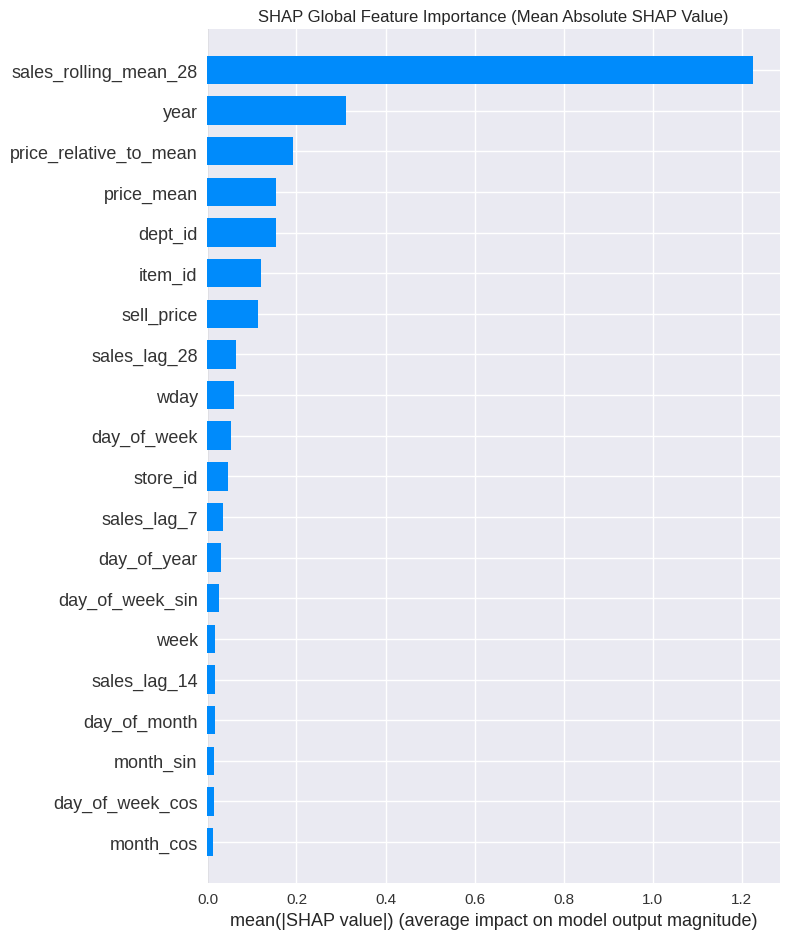

<Figure size 800x550 with 0 Axes>

In [40]:
print("Generating Global Importance plot (Bar)...")
plt.figure()
plt.title("SHAP Global Feature Importance (Mean Absolute SHAP Value)")
shap.summary_plot(shap_values, X_valid_sample, plot_type="bar")
plt.savefig('shap_global_importance.png')

Summary Plot (Beeswarm Plot)
This is the most powerful plot. It shows the importance, impact, and the original value all at once.

When the 7-day rolling mean was high (red), it strongly increased the sales prediction. When the rolling mean was low (blue), it strongly decreased the prediction.

Generating Summary plot (Beeswarm)...


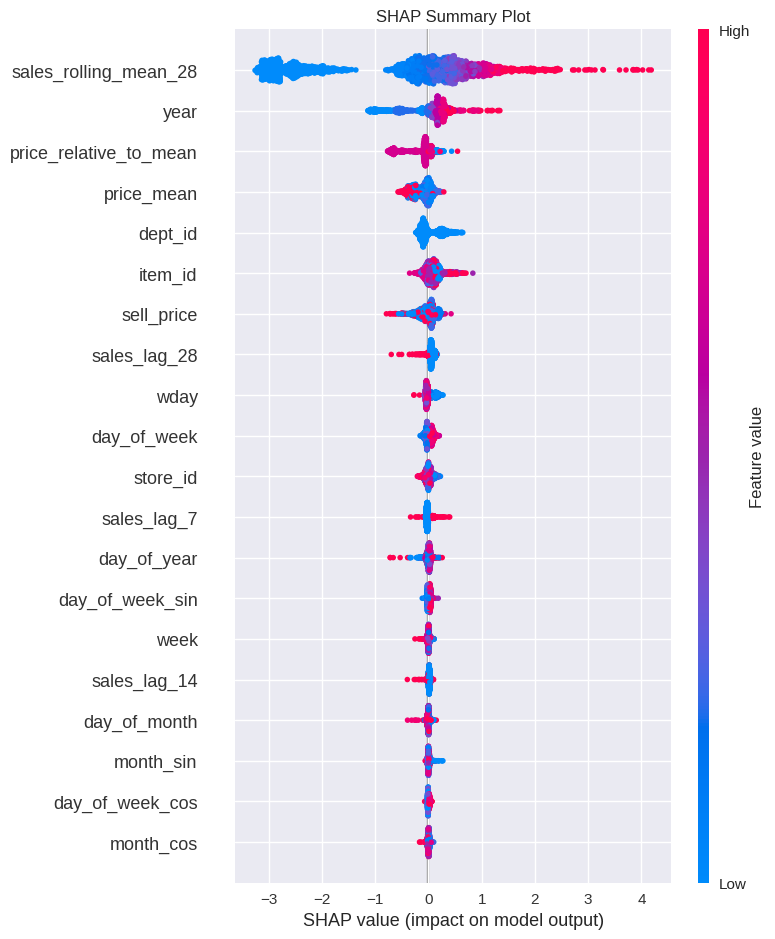

<Figure size 800x550 with 0 Axes>

In [41]:
print("Generating Summary plot (Beeswarm)...")
plt.figure(figsize=(18, 10))
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_valid_sample)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
# plt.show()

 99%|===================| 1976/2000 [00:47<00:00]       


Generating Waterfall plot for one prediction...


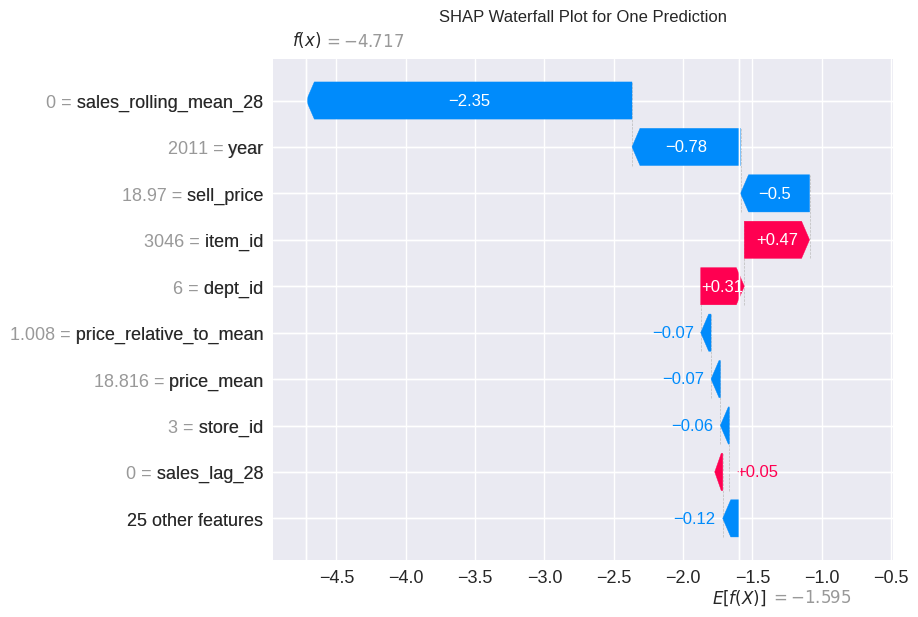

<Figure size 800x550 with 0 Axes>

In [42]:
shap_explanation = explainer(X_valid_sample)

print("\nGenerating Waterfall plot for one prediction...")
plt.figure()
plt.title("SHAP Waterfall Plot for One Prediction")
shap.waterfall_plot(shap_explanation[0])
plt.savefig('shap_waterfall_plot.png')
plt.show()

In [43]:
gc.collect()

29835